In [ ]:
import math
import time

class SemiGlobalMatching:
    def __init__(self):
        self.width = 0
        self.height = 0
        self.img_left = None
        self.img_right = None
        self.census_left = None
        self.census_right = None
        self.cost_init = None
        self.cost_aggr = None
        self.cost_aggr_1 = None
        self.cost_aggr_2 = None
        self.cost_aggr_3 = None
        self.cost_aggr_4 = None
        self.cost_aggr_5 = None
        self.cost_aggr_6 = None
        self.cost_aggr_7 = None
        self.cost_aggr_8 = None
        self.disp_left = None
        self.disp_right = None
        self.is_initialized = False

    def __del__(self):
        self.release()
        self.is_initialized = False

    def initialize(self, width, height, option):
        # ··· Assignments

        # Image dimensions
        self.width = width
        self.height = height
        # SGM parameters
        self.option = option

        if width == 0 or height == 0:
            return False

        # ··· Allocate memory

        # Census values (left and right images)
        img_size = width * height
        if option.census_size == "Census5x5":
            self.census_left = [0] * img_size
            self.census_right = [0] * img_size
        else:
            self.census_left = [0] * img_size
            self.census_right = [0] * img_size

        # Disparity range
        disp_range = option.max_disparity - option.min_disparity
        if disp_range <= 0:
            return False

        # Matching costs (initial and aggregated)
        size = width * height * disp_range
        self.cost_init = [0] * size
        self.cost_aggr = [0] * size
        self.cost_aggr_1 = [0] * size
        self.cost_aggr_2 = [0] * size
        self.cost_aggr_3 = [0] * size
        self.cost_aggr_4 = [0] * size
        self.cost_aggr_5 = [0] * size
        self.cost_aggr_6 = [0] * size
        self.cost_aggr_7 = [0] * size
        self.cost_aggr_8 = [0] * size

        # Disparity maps
        self.disp_left = [0.0] * img_size
        self.disp_right = [0.0] * img_size

        self.is_initialized = all(
            [
                self.census_left,
                self.census_right,
                self.cost_init,
                self.cost_aggr,
                self.disp_left,
            ]
        )

        return self.is_initialized

    def match(self, img_left, img_right, disp_left):
        if not self.is_initialized:
            return False
        if img_left is None or img_right is None:
            return False

        self.img_left_ = img_left
        self.img_right_ = img_right

        start = time.time()

        # Census transform
        self.census_transform()

        # Compute cost
        self.compute_cost()

        end = time.time()
        tt = end - start
        print(f"computing cost! timing: {tt:.6f} s")
        start = time.time()

        # Cost aggregation
        self.cost_aggregation()

        end = time.time()
        tt = end - start
        print(f"cost aggregating! timing: {tt:.6f} s")
        start = time.time()

        # Compute disparity
        self.compute_disparity()

        end = time.time()
        tt = end - start
        print(f"computing disparities! timing: {tt:.6f} s")
        start = time.time()

        # Left-right consistency check
        if self.option.is_check_lr:
            # Compute disparity (right image)
            self.compute_disparity_right()
            # LR consistency check
            self.lr_check()

        # Remove small speckles
        if self.option.is_remove_speckles:
            sgm_util.remove_speckles(
                self.disp_left_,
                self.width_,
                self.height_,
                1,
                self.option.min_speckle_area,
                float("inf"),
            )

        # Disparity filling
        if self.option.is_fill_holes:
            self.fill_holes_in_disp_map()

        # Median filter
        sgm_util.median_filter(
            self.disp_left_, self.disp_left_, self.width_, self.height_, 3
        )

        end = time.time()
        tt = end - start
        print(f"postprocessing! timing: {tt:.6f} s")
        start = time.time()

        # Output disparity map
        disp_left[:] = self.disp_left_

        return True

    def census_transform(self):
        # 左右影像的 Census 变换
        if self.option.census_size == "Census5x5":
            sgm_util.census_transform_5x5(
                self.img_left_, self.census_left, self.width, self.height
            )
            sgm_util.census_transform_5x5(
                self.img_right_, self.census_right, self.width, self.height
            )
        else:
            sgm_util.census_transform_9x7(
                self.img_left_, self.census_left, self.width, self.height
            )
            sgm_util.census_transform_9x7(
                self.img_right_, self.census_right, self.width, self.height
            )

    def compute_cost(self):
        min_disparity = self.option.min_disparity
        max_disparity = self.option.max_disparity
        disp_range = max_disparity - min_disparity
        if disp_range <= 0:
            return

        # 基于 Hamming 距离计算代价
        for i in range(self.height):
            for j in range(self.width):
                # 逐视差计算代价值
                for d in range(min_disparity, max_disparity):
                    cost_index = (
                        i * self.width * disp_range
                        + j * disp_range
                        + (d - min_disparity)
                    )
                    if j - d < 0 or j - d >= self.width:
                        self.cost_init[cost_index] = 255 // 2
                        continue
                    if self.option.census_size == "Census5x5":
                        # 左影像的 Census 值
                        census_val_l = self.census_left[i * self.width + j]
                        # 右影像对应像点的 Census 值
                        census_val_r = self.census_right[i * self.width + j - d]
                        # 计算匹配代价
                        self.cost_init[cost_index] = sgm_util.hamming32(
                            census_val_l, census_val_r
                        )
                    else:
                        census_val_l = self.census_left[i * self.width + j]
                        census_val_r = self.census_right[i * self.width + j - d]
                        self.cost_init[cost_index] = sgm_util.hamming64(
                            census_val_l, census_val_r
                        )

    def cost_aggregation(self):
        # Path aggregation
        # 1. Left->Right / Right->Left
        # 2. Up->Down / Down->Up
        # 3. Top-left->Bottom-right / Bottom-right->Top-left
        # 4. Top-right->Bottom-left / Bottom-left->Top-right
        #
        # ↘ ↓ ↙   5  3  7
        # →    ←	 1    2
        # ↗ ↑ ↖   8  4  6
        #
        min_disparity = self.option.min_disparity
        max_disparity = self.option.max_disparity
        assert max_disparity > min_disparity

        size = self.width * self.height * (max_disparity - min_disparity)
        if size <= 0:
            return

        P1 = self.option.p1
        P2_Int = self.option.p2_init

        if self.option.num_paths == 4 or self.option.num_paths == 8:
            # Left-right aggregation
            sgm_util.cost_aggregate_left_right(
                self.img_left_,
                self.width,
                self.height,
                min_disparity,
                max_disparity,
                P1,
                P2_Int,
                self.cost_init,
                self.cost_aggr_1_,
                True,
            )
            sgm_util.cost_aggregate_left_right(
                self.img_left_,
                self.width,
                self.height,
                min_disparity,
                max_disparity,
                P1,
                P2_Int,
                self.cost_init,
                self.cost_aggr_2_,
                False,
            )
            # Up-down aggregation
            sgm_util.cost_aggregate_up_down(
                self.img_left_,
                self.width,
                self.height,
                min_disparity,
                max_disparity,
                P1,
                P2_Int,
                self.cost_init,
                self.cost_aggr_3_,
                True,
            )
            sgm_util.cost_aggregate_up_down(
                self.img_left_,
                self.width,
                self.height,
                min_disparity,
                max_disparity,
                P1,
                P2_Int,
                self.cost_init,
                self.cost_aggr_4_,
                False,
            )

        if self.option.num_paths == 8:
            # Diagonal 1 aggregation
            sgm_util.cost_aggregate_diagonal_1(
                self.img_left_,
                self.width,
                self.height,
                min_disparity,
                max_disparity,
                P1,
                P2_Int,
                self.cost_init,
                self.cost_aggr_5_,
                True,
            )
            sgm_util.cost_aggregate_diagonal_1(
                self.img_left_,
                self.width,
                self.height,
                min_disparity,
                max_disparity,
                P1,
                P2_Int,
                self.cost_init,
                self.cost_aggr_6_,
                False,
            )
            # Diagonal 2 aggregation
            sgm_util.cost_aggregate_diagonal_2(
                self.img_left_,
                self.width,
                self.height,
                min_disparity,
                max_disparity,
                P1,
                P2_Int,
                self.cost_init,
                self.cost_aggr_7_,
                True,
            )
            sgm_util.cost_aggregate_diagonal_2(
                self.img_left_,
                self.width,
                self.height,
                min_disparity,
                max_disparity,
                P1,
                P2_Int,
                self.cost_init,
                self.cost_aggr_8_,
                False,
            )

        # Combine the 4/8 directions
        for i in range(size):
            if self.option.num_paths == 4 or self.option.num_paths == 8:
                self.cost_aggr_[i] = (
                    self.cost_aggr_1_[i]
                    + self.cost_aggr_2_[i]
                    + self.cost_aggr_3_[i]
                    + self.cost_aggr_4_[i]
                )
            if self.option.num_paths == 8:
                self.cost_aggr_[i] += (
                    self.cost_aggr_5_[i]
                    + self.cost_aggr_6_[i]
                    + self.cost_aggr_7_[i]
                    + self.cost_aggr_8_[i]
                )

    def compute_disparity(self):
        min_disparity = self.option.min_disparity
        max_disparity = self.option.max_disparity
        disp_range = max_disparity - min_disparity
        if disp_range <= 0:
            return

        # Left image disparity map
        disparity = self.disp_left_
        # Left image aggregated cost array
        cost_ptr = self.cost_aggr_

        width = self.width
        height = self.height
        is_check_unique = self.option.is_check_unique
        uniqueness_ratio = self.option.uniqueness_ratio

        # To speed up reading, store all cost values for a single pixel in a local array
        cost_local = [0] * disp_range

        # --- Calculate optimal disparity pixel by pixel
        for i in range(height):
            for j in range(width):
                min_cost = float("inf")
                sec_min_cost = float("inf")
                best_disparity = 0

                # --- Traverse all cost values within the disparity range, output the minimum cost and its corresponding disparity
                for d in range(min_disparity, max_disparity):
                    d_idx = d - min_disparity
                    cost = cost_local[d_idx] = cost_ptr[
                        i * width * disp_range + j * disp_range + d_idx
                    ]
                    if min_cost > cost:
                        min_cost = cost
                        best_disparity = d

                if is_check_unique:
                    # Traverse again to output the second minimum cost
                    for d in range(min_disparity, max_disparity):
                        if d == best_disparity:
                            # Skip the minimum cost
                            continue
                        cost = cost_local[d - min_disparity]
                        sec_min_cost = min(sec_min_cost, cost)

                    # Check uniqueness constraint
                    # If (min-sec)/min < min*(1-uniqueness), then it is an invalid estimate
                    if sec_min_cost - min_cost <= min_cost * (1 - uniqueness_ratio):
                        disparity[i * width + j] = float("inf")
                        continue

                # --- Subpixel interpolation
                if best_disparity == min_disparity or best_disparity == max_disparity - 1:
                    disparity[i * width + j] = float("inf")
                    continue
                # Cost values for the disparity before and after the best disparity
                idx_1 = best_disparity - 1 - min_disparity
                idx_2 = best_disparity + 1 - min_disparity
                cost_1 = cost_local[idx_1]
                cost_2 = cost_local[idx_2]
                # Solve the extremum of a quadratic curve
                denom = max(1, cost_1 + cost_2 - 2 * min_cost)
                disparity[i * width + j] = best_disparity + (cost_1 - cost_2) / (
                    denom * 2.0
                )

    def compute_disparity_right(self):
        min_disparity = self.option.min_disparity
        max_disparity = self.option.max_disparity
        disp_range = max_disparity - min_disparity
        if disp_range <= 0:
            return

        # Right image disparity map
        disparity = self.disp_right_
        # Left image aggregated cost array
        cost_ptr = self.cost_aggr_

        width = self.width
        height = self.height
        is_check_unique = self.option.is_check_unique
        uniqueness_ratio = self.option.uniqueness_ratio

        # To speed up reading, store all cost values for a single pixel in a local array
        cost_local = [0] * disp_range

        # --- Calculate optimal disparity pixel by pixel
        # Obtain right image cost using left image cost
        # Right cost(xr, yr, d) = Left cost(xr + d, yl, d)
        for i in range(height):
            for j in range(width):
                min_cost = float("inf")
                sec_min_cost = float("inf")
                best_disparity = 0

                # --- Collect cost values for candidate disparities
                for d in range(min_disparity, max_disparity):
                    d_idx = d - min_disparity
                    col_left = j + d
                    if 0 <= col_left < width:
                        cost = cost_local[d_idx] = cost_ptr[
                            i * width * disp_range + col_left * disp_range + d_idx
                        ]
                        if min_cost > cost:
                            min_cost = cost
                            best_disparity = d
                    else:
                        cost_local[d_idx] = float("inf")

                if is_check_unique:
                    # Traverse again to find the second minimum cost
                    for d in range(min_disparity, max_disparity):
                        if d == best_disparity:
                            # Skip the minimum cost
                            continue
                        cost = cost_local[d - min_disparity]
                        sec_min_cost = min(sec_min_cost, cost)

                    # Check uniqueness constraint
                    # If (min-sec)/min < min*(1-uniqueness), then it is an invalid estimate
                    if sec_min_cost - min_cost <= min_cost * (1 - uniqueness_ratio):
                        disparity[i * width + j] = float("inf")
                        continue

                # --- Subpixel interpolation
                if best_disparity == min_disparity or best_disparity == max_disparity - 1:
                    disparity[i * width + j] = float("inf")
                    continue

                # Cost values for the disparity before and after the best disparity
                idx_1 = best_disparity - 1 - min_disparity
                idx_2 = best_disparity + 1 - min_disparity
                cost_1 = cost_local[idx_1]
                cost_2 = cost_local[idx_2]
                # Solve the extremum of a quadratic curve
                denom = max(1, cost_1 + cost_2 - 2 * min_cost)
                disparity[i * width + j] = best_disparity + (cost_1 - cost_2) / (
                    denom * 2.0
                )

    def lr_check(self):
        width = self.width_
        height = self.height_

        threshold = self.option.lrcheck_thres

        # Lists to store occluded and mismatched pixels
        occlusions = []
        mismatches = []

        # --- Left-right consistency check
        for i in range(height):
            for j in range(width):
                # Left image disparity value
                disp = self.disp_left_[i * width + j]
                if disp == float("inf"):
                    mismatches.append((i, j))
                    continue

                # Find the corresponding pixel in the right image based on the disparity value
                col_right = int(j - disp + 0.5)

                if 0 <= col_right < width:
                    # Disparity value of the corresponding pixel in the right image
                    disp_r = self.disp_right_[i * width + col_right]

                    # Check if the two disparity values are consistent (within the threshold)
                    if abs(disp - disp_r) > threshold:
                        # Distinguish between occluded and mismatched pixels
                        # Calculate the matching pixel in the left image using the disparity value from the right image (disp_rl)
                        # if disp_rl > disp:
                        #     pixel in occlusions
                        # else:
                        #     pixel in mismatches
                        col_rl = int(col_right + disp_r + 0.5)
                        if 0 < col_rl < width:
                            disp_l = self.disp_left_[i * width + col_rl]
                            if disp_l > disp:
                                occlusions.append((i, j))
                            else:
                                mismatches.append((i, j))
                        else:
                            mismatches.append((i, j))

                        # Invalidate the disparity value
                        disp = float("inf")
                else:
                    # Cannot find a corresponding pixel in the right image (out of image bounds)
                    disp = float("inf")
                    mismatches.append((i, j))


    def fill_holes_in_disp_map(self):
        width = self.width_
        height = self.height_

        disp_collects = []

        # Define 8 directions
        pi = 3.1415926
        angle1 = [pi, 3 * pi / 4, pi / 2, pi / 4, 0, 7 * pi / 4, 3 * pi / 2, 5 * pi / 4]
        angle2 = [pi, 5 * pi / 4, 3 * pi / 2, 7 * pi / 4, 0, pi / 4, pi / 2, 3 * pi / 4]
        angle = angle1
        # Maximum search length, no need to search too far pixels
        max_search_length = 1.0 * max(
            abs(self.option.max_disparity), abs(self.option.min_disparity)
        )

        disp_ptr = self.disp_left_
        for k in range(3):
            # First loop handles occluded pixels, second loop handles mismatched pixels
            trg_pixels = self.occlusions_ if k == 0 else self.mismatches_
            if not trg_pixels:
                continue
            fill_disps = [0] * len(trg_pixels)
            inv_pixels = []
            if k == 2:
                # Third loop handles pixels not fully processed in the first two loops
                for i in range(height):
                    for j in range(width):
                        if disp_ptr[i * width + j] == float("inf"):
                            inv_pixels.append((i, j))
                trg_pixels = inv_pixels

            # Traverse pixels to be processed
            for n, pix in enumerate(trg_pixels):
                y, x = pix
                if y == height // 2:
                    angle = angle2

                # Collect the first valid disparity value encountered in 8 directions
                disp_collects.clear()
                for s in range(8):
                    ang = angle[s]
                    sina = float(sin(ang))
                    cosa = float(cos(ang))
                    for m in range(1, int(max_search_length)):
                        yy = round(y + m * sina)
                        xx = round(x + m * cosa)
                        if not (0 <= yy < height and 0 <= xx < width):
                            break
                        disp = disp_ptr[yy * width + xx]
                        if disp != float("inf"):
                            disp_collects.append(disp)
                            break
                if not disp_collects:
                    continue

                disp_collects.sort()

                # If it's an occluded pixel, choose the second smallest disparity value
                # If it's a mismatched pixel, choose the median
                if k == 0:
                    fill_disps[n] = (
                        disp_collects[1] if len(disp_collects) > 1 else disp_collects[0]
                    )
                else:
                    fill_disps[n] = disp_collects[len(disp_collects) // 2]

            for n, pix in enumerate(trg_pixels):
                y, x = pix
                disp_ptr[y * width + x] = fill_disps[n]

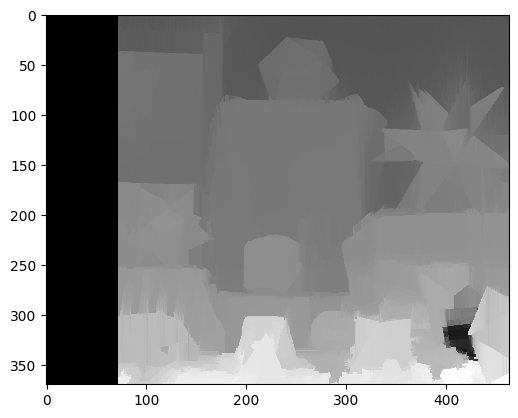

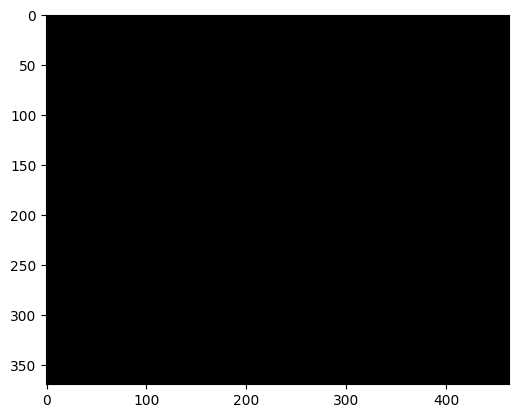

In [31]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


def opencv_SGBM(left_img, right_img, use_wls=True, sgbm="param1"):
    channels = 1 if left_img.ndim == 2 else 3
    blockSize = 6
    if sgbm == "param1":
        paramL = {
            "minDisparity": 8,
            "numDisparities": 4 * 16,
            "blockSize": blockSize,
            "P1": 8 * 3 * blockSize,
            "P2": 32 * 3 * blockSize,
            "disp12MaxDiff": 12,
            "uniquenessRatio": 10,
            "speckleWindowSize": 50,
            "speckleRange": 32,
            "preFilterCap": 63,
            "mode": cv2.STEREO_SGBM_MODE_SGBM_3WAY,
        }
    elif sgbm == "param2":
        paramL = {
            "minDisparity": 0,
            "numDisparities": 5 * 16,
            "blockSize": blockSize * 3,
            "P1": 8 * 3 * blockSize,
            "P2": 32 * 3 * blockSize,
            "disp12MaxDiff": 50,
            "uniquenessRatio": 6,
            "speckleWindowSize": 150,
            "speckleRange": 32,
            "preFilterCap": 63,
            "mode": cv2.STEREO_SGBM_MODE_SGBM_3WAY,
        }
    else:
        paramL = {
            "minDisparity": 0,
            "numDisparities": 128,
            "blockSize": blockSize,
            "P1": 8 * channels * blockSize**2,
            "P2": 32 * channels * blockSize**2,
            "disp12MaxDiff": 1,
            "preFilterCap": 63,
            "uniquenessRatio": 15,
            "speckleWindowSize": 100,
            "speckleRange": 1,
            "mode": cv2.STEREO_SGBM_MODE_SGBM_3WAY,
        }

    matcherL = cv2.StereoSGBM_create(**paramL)
    # 计算左视差图
    dispL = matcherL.compute(left_img, right_img)
    dispL = np.int16(dispL)

    # WLS滤波平滑优化图像
    if use_wls:
        paramR = paramL
        paramR['minDisparity'] = -paramL['numDisparities']
        matcherR = cv2.StereoSGBM_create(**paramR)
        #matcherR = cv2.ximgproc.createRightMatcher(matcherL)
        dispR = matcherR.compute(right_img, left_img)
        dispR = np.int16(dispR)
        lmbda = 80000
        sigma = 1.3
        filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=matcherL)
        filter.setLambda(lmbda)
        filter.setSigmaColor(sigma)
        dispL = filter.filter(dispL, left_img, None, dispR)
        dispL = np.int16(dispL)
        dispR = filter.filter(dispR, left_img, None, dispL)
    # 除以16得到真实视差（因为SGBM算法得到的视差是×16的）
    dispL[dispL < 0] = 0
    dispL = dispL.astype(np.float32) / 16.0
    cv2.imwrite("dispL.png", dispL)
    plt.imshow(dispL, "gray")
    plt.show()

    dispR[dispR < 0] = 0
    dispR = dispR.astype(np.float32) / 16.0
    cv2.imwrite("dispR.png", dispR)
    plt.imshow(dispR, "gray")
    plt.show()


if __name__ == "__main__":
    left = cv2.imread("imgs/view1.png", 0)
    right = cv2.imread("imgs/view5.png", 0)
    opencv_SGBM(left, right)